# Missing Migrants Visualization

* David Beach - CS573 Data Visualization
* D3 Detox Assignment
* October 1, 2017

## Overview

The visualizations below were created using Python, Pandas, Matplotlib, and the Jupyter Notebook.

This assignment submission entails a complete copy of the Jupyter notebook used to create the visuals.  Read further down to see code, visualizations, descriptions, and summary text.


In [1]:
import datetime as dt
from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load Data

We begin by loading the data into a Pandas data frame.

In [2]:
data = pd.read_csv("../data/raw/MissingMigrants.csv", encoding='iso-8859-1')
data.columns

Index(['id', 'cause_of_death', 'region_origin', 'affected_nationality',
       'missing', 'dead', 'incident_region', 'date', 'source', 'reliability',
       'lat', 'lon'],
      dtype='object')


## Column Names and Types

Here is an overview of the columns in the data set.

### ID

  - Categorical
  - Unique Event Identifier

### Cause of Death

  - Qualitative
  - Free-form text
  - Requires classification into categories to be useful
  - Developed a cleaning algorithm which converts this to a subset

### Region of Origin

  - Categorical
  - Imperfect data / required cleaning to obtain better categories

### Nationality

  - Categorical
  - Includes origin nation name, but also has free-form text
  - Compare to list of country names (other data) to get clean categories?

### Missing

  - Quantitative, Integer

### Dead

  - Quantitative, Integer

### Incident Region

  - Categorical
  - mostly clean
  - but can also be computed from lat/lon

### Date

  - Quantitative
  - appears to be clean

### Source

  - Categorical
  - fairly high cardinality (603)
  - may be difficult to use unless we can reduce the number of categories

### Reliability

  - Categorical
  - Almost clean, but has capitalization differences
  - Should reduce to:
    - Verified
    - Partially Verified
    - Unverified

### Latitude

  - Quantitative

### Longitude

  - Quantitative


## Index and clean data

The `id` column is a unique identifier and should be treated as an index into the data set.

The number of `dead` and `missing` are sometimes left blank (presumed zero).  We will zero-fill any N/A values from either of these columns.

In [3]:
def sub(series, value1, value2):
    return np.where(series == value1, value2, series)

In [4]:
data.index = data.id

# fill null values in dead, missing counts
data.dead = data.dead.fillna(0.0)
data.missing = data.missing.fillna(0.0)

# parse dates
data.date = pd.to_datetime(data.date, format='%d/%m/%Y')

# fill missing values in nationality with empty string
data.region_origin = data.region_origin.fillna("Unknown")
data.affected_nationality = data.affected_nationality.fillna("Unknown")
data.source = data.source.fillna("Unknown")
data.incident_region = data.incident_region.fillna("Unknown")

# translate "Horn of Africa (P)" --> "Horn of Africa"
data.region_origin = sub(data.region_origin, 'Horn of Africa (P)', "Horn of Africa")
data.region_origin = sub(data.region_origin, 'Middle East/ South Asia', "Middle East / South Asia")

# translate "Middle East " --> "Middle East"
data.incident_region = sub(data.incident_region, "Middle East ", "Middle East")

# translate "Central America incl. Mexico" --> "Central America & Mexico" (for consistency)
data.incident_region = sub(data.incident_region, "Central America incl. Mexico", "Central America & Mexico")

# clean inconsistencies in reliability data
data.reliability = data.reliability.fillna('Unverified')
data.reliability = sub(data.reliability, "Partially verified", "Partially Verified")

## Regions

Confirm that translated categories appear clean.

In [5]:
sorted(data.incident_region.unique())

['Caribbean',
 'Central America & Mexico',
 'East Asia',
 'Europe',
 'Horn of Africa',
 'Mediterranean',
 'Middle East',
 'North Africa',
 'North America',
 'South America',
 'Southeast Asia',
 'Sub-Saharan Africa',
 'U.S./Mexico Border',
 'Unknown']

In [6]:
sorted(data.region_origin.unique())

['Caribbean',
 'Central America',
 'Central America & Mexico',
 'East Asia',
 'Horn of Africa',
 'MENA',
 'Middle East',
 'Middle East / South Asia',
 'Mixed',
 'North Africa',
 'South America',
 'South Asia',
 'South East Asia',
 'Southern Europe',
 'Sub-Saharan Africa',
 'Unknown']

In [7]:
data.reliability.unique()

array(['Verified', 'Partially Verified', 'Unverified'], dtype=object)

## Nationalities

Examine set of mapped countries after processing text.

In [8]:
import countries
from importlib import reload
reload(countries)
data['nationalities'] = data.affected_nationality.apply(countries.extract_countries)

In [9]:
sorted(set(c for countries in data.nationalities for c in countries))

['Afghanistan',
 'Albania',
 'Algeria',
 'Bangladesh',
 'Benin',
 'Brazil',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Central African Republic (CAR)',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 "Cote d'Ivoire",
 'Cuba',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Ethiopia',
 'Gambia',
 'Ghana',
 'Guatemala',
 'Guinea',
 'Haiti',
 'Honduras',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Lebanon',
 'Liberia',
 'Libya',
 'Madagascar',
 'Malawi',
 'Malaysia',
 'Mali',
 'Mauritania',
 'Mauritius',
 'Mexico',
 'Morocco',
 'Mozambique',
 'Myanmar (Burma)',
 'Nepal',
 'Nicaragua',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Palestine',
 'Peru',
 'Senegal',
 'Sierra Leone',
 'Somalia',
 'Sudan',
 'Syria',
 'Tunisia',
 'Turkey',
 'Unknown',
 'Venezuela',
 'Yemen',
 'Zambia',
 'Zimbabwe']

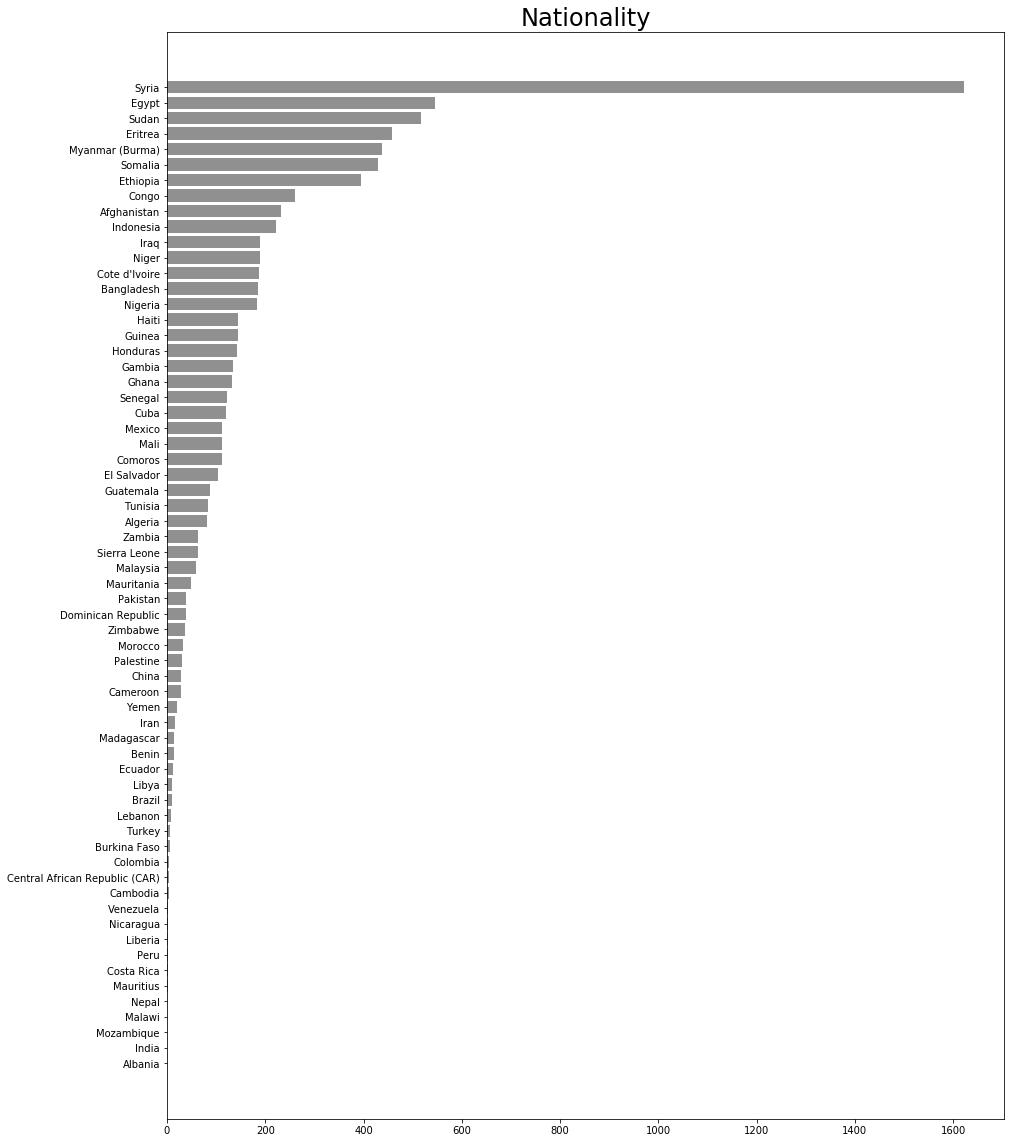

In [10]:
event_vals = defaultdict(lambda: 0)
for index, row in data.iterrows():
    num = len(row.nationalities)
    for country in row.nationalities:
        event_vals[country] += (row.dead + row.missing) / num
del event_vals["Unknown"]
        
uniq_nationalities = list(event_vals.keys())
uniq_nationalities.sort(key=lambda x: event_vals[x])
        
fig, ax = plt.subplots(figsize=(15,20))

ax.barh(range(len(uniq_nationalities)), [event_vals[c] for c in uniq_nationalities], color="#909090")
ax.set_title("Nationality", fontsize=24)
ax.set_yticks(range(len(uniq_nationalities)))
ax.set_yticklabels(uniq_nationalities)

plt.show()

## Cause of Death

I'm especially interested in the cause of death field for this analysis.  Unfortunately, the field is free-form text, and there is no consistency in the way it has been encoded.

To overcome this challenge, I have developed an alogrithm which classifies the cause of death based on substring matches found in the text.  The algorithm was developed iteratively and repeatedly spot-checked.  It appears to be reasonably accurate.

After several iterations, I reduced the data to the following broad categories:

  * Drowning/Asphyxiation -- lack of oxygen
  * Exposure -- due to lack of food, water, shelter or appropriate clothing
  * Vehicular/Mechanical -- due to vehicles, falling, crushing, burns, or other trauma
  * Violence/Homicide -- caused by human violence, fighting, weapons, etc.
  * Medical/Illness -- due to medical condition or illness
  * Unknown -- missing values, or causes where cause is specifically labelled as unknown/other
  
The cause names, patterns, and colormap can be found in the constants below.  Finally, we augment the data frame with the result of this computed column.

In [11]:
CAUSE_PATTERNS = [
    ('Drowning/Asphyxiation', ['drown', 'asphyx', 'suffoc', 'aspiration']),
    ('Exposure', ['exposure', 'hypothermia', 'hyperthermia', 'weather', 'shelter', 'exhaust', 'condition', 'fatigue', 'starv', 'nourish', 'dehydrat', 'hunger']),
    ('Vehicular/Mechanical', ['vehicle', 'truck', 'van', 'train', 'car', 'crush', 'fall', 'fell', 'trauma', 'electrocut', 'burn', 'fire', 'injury', 'road accident', 'motor', 'fumes', 'landmine']),
    ('Violence/Homicide', ['homicide', 'murder', 'murdur', 'killed', 'beat', 'shot', 'violen', 'stab', 'blunt force', 'abuse', 'torture', 'assault', 'poison', 'fight']),
    ('Medical/Illness', ['sick', 'ill', 'virus', 'flu', 'cancer', 'heart attack', 'glycemic', 'renal', 'pulmonary', 'gylcemic', 'diabetic', 'meningitis', 'infection', 'broncho', 'digestive']),
    ('Unknown', ['unknown']),
]
CAUSES = [cause for cause, _ in CAUSE_PATTERNS]
CAUSE_COLORMAP = {
    'Drowning/Asphyxiation': '#60B0FF',
    'Exposure': '#ff8c0a',
    'Vehicular/Mechanical': '#5e5e5e', 
    'Violence/Homicide': '#cc0000', 
    'Medical/Illness': '#81c100',
    'Unknown': '#d8c6ff'
}

def get_causes(cause_str):
    """Parse cause-of-death text, returning a list of one or more categories."""
    cause_str = str(cause_str).lower()
    causes = []
    for cause, patterns in CAUSE_PATTERNS:
        for pattern in patterns:
            if pattern in cause_str:
                causes.append(cause)
                break
    if not causes:
        causes.append('Unknown')
    return causes

In [12]:
data['causes'] = data.cause_of_death.apply(get_causes)

## Cause of Death per Event

Each incident has one or more causes of death associated with.  The following pie chart shows the proportion of causes associated with each incident.  Multi-causal incidents are counted once per each cause category.

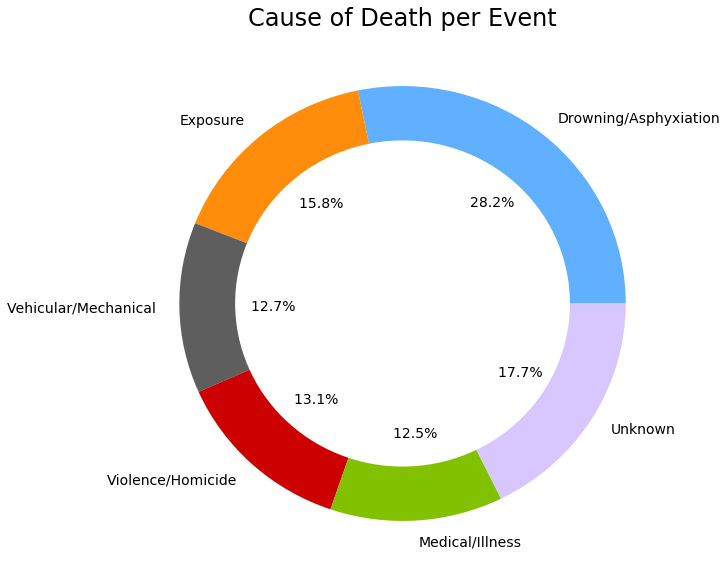

In [13]:
event_vals = defaultdict(lambda: 0)
for index, row in data.iterrows():
    for cause in row.causes:
        event_vals[cause] += 1

plt.figure(figsize=(10,10))
plt.pie([event_vals[c] for c in CAUSES], labels=CAUSES,
        colors=[CAUSE_COLORMAP[c] for c in CAUSES],
        autopct="%6.1f%%",
        textprops={"fontsize": 14}
       )
plt.title("Cause of Death per Event", fontsize=24)

centre_circle = plt.Circle((0,0),0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

## Cause of Death/Missing Frequency

Each event includes a count of `dead` and `missing` migrants.  In the twin pie charts below, we examine the distribution of causes when tallied according to these numbers.

We note two things in particular:

1. Drowinings are much more frequent in these charts, presumably because group drownings can occur due to boats sinking.  This suggests that for many migrants, crossing water is the most perilous part of the journey.

2. Missing migrant cases are almost entirely attributed to drowning.  Exposure and Violence play smaller roles, and other labels (such as Illness and Violence) are essentially unused for these missing cases.


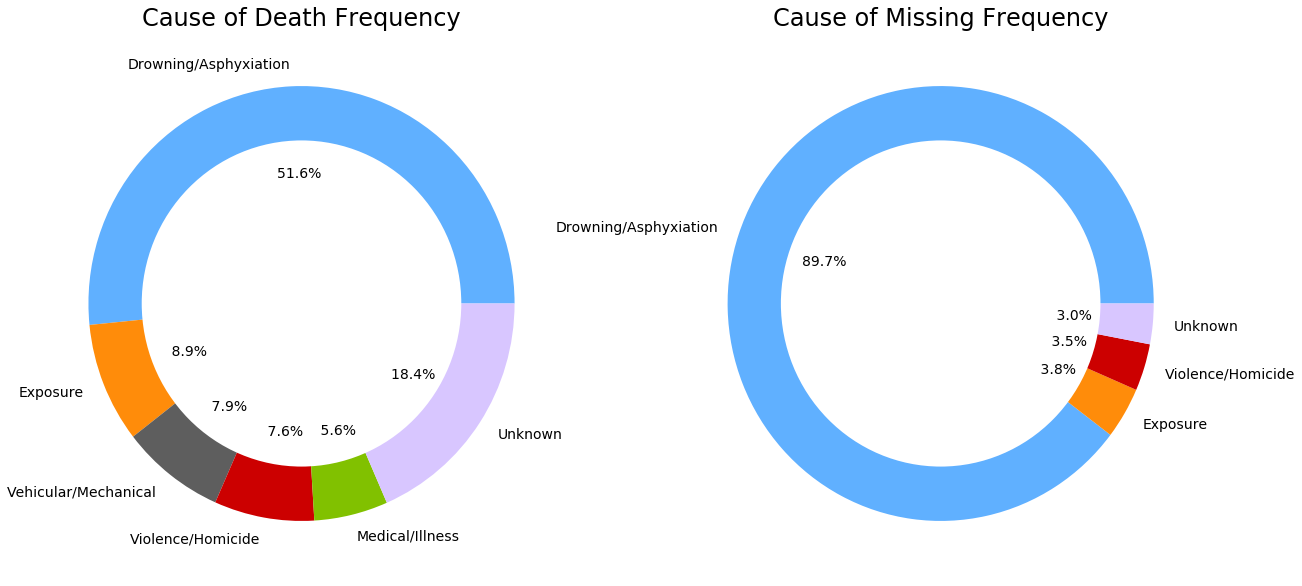

In [14]:
missing_vals = defaultdict(lambda: 0.0)
dead_vals = defaultdict(lambda: 0.0)
for index, row in data.iterrows():
    ncauses = len(row["causes"])
    nper = row.dead / ncauses
    for cause in row["causes"]:
        missing_vals[cause] += row.missing / ncauses
        dead_vals[cause] += row.dead / ncauses
        
# clean up missing values
tot = float(sum(v for v in missing_vals.values()))
for cause, val in list(missing_vals.items()):
    if (val/tot) < 0.005:
        del missing_vals[cause]

plt.figure(figsize=(21,10))
plt.subplot(1,2,1)
plt.pie([dead_vals[c] for c in CAUSES],
        labels=CAUSES,
        colors=[CAUSE_COLORMAP[c] for c in CAUSES],
        autopct="%6.1f%%",
        textprops={"fontsize": 14},
       )
plt.title("Cause of Death Frequency", fontsize=24)
centre_circle = plt.Circle((0,0),0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.subplot(1,2,2)
plt.pie([missing_vals[c] for c in CAUSES if c in missing_vals],
        labels=[c for c in CAUSES if c in missing_vals],
        colors=[CAUSE_COLORMAP[c] for c in CAUSES if c in missing_vals],
        autopct="%6.1f%%",
        textprops={"fontsize": 14}
       )
plt.title("Cause of Missing Frequency", fontsize=24)
centre_circle = plt.Circle((0,0),0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

## Migrant Death Locations


In the bubble chart below, we show the geographic locations of each event, with circle area proportional to the total of `dead` + `missing`.  The events are colored using the same cause-of-death categories employed in the pie charts above.

Examining this map, one can see regions which involve more drownings (presumably over water), whereas other areas reveal patterns of exposure (orange), mechanical/vehicular accidents (dark grey), as well as concentrations of human violence (red).  Deaths due to illness (green) appear to be more frequent at topical latitudes.

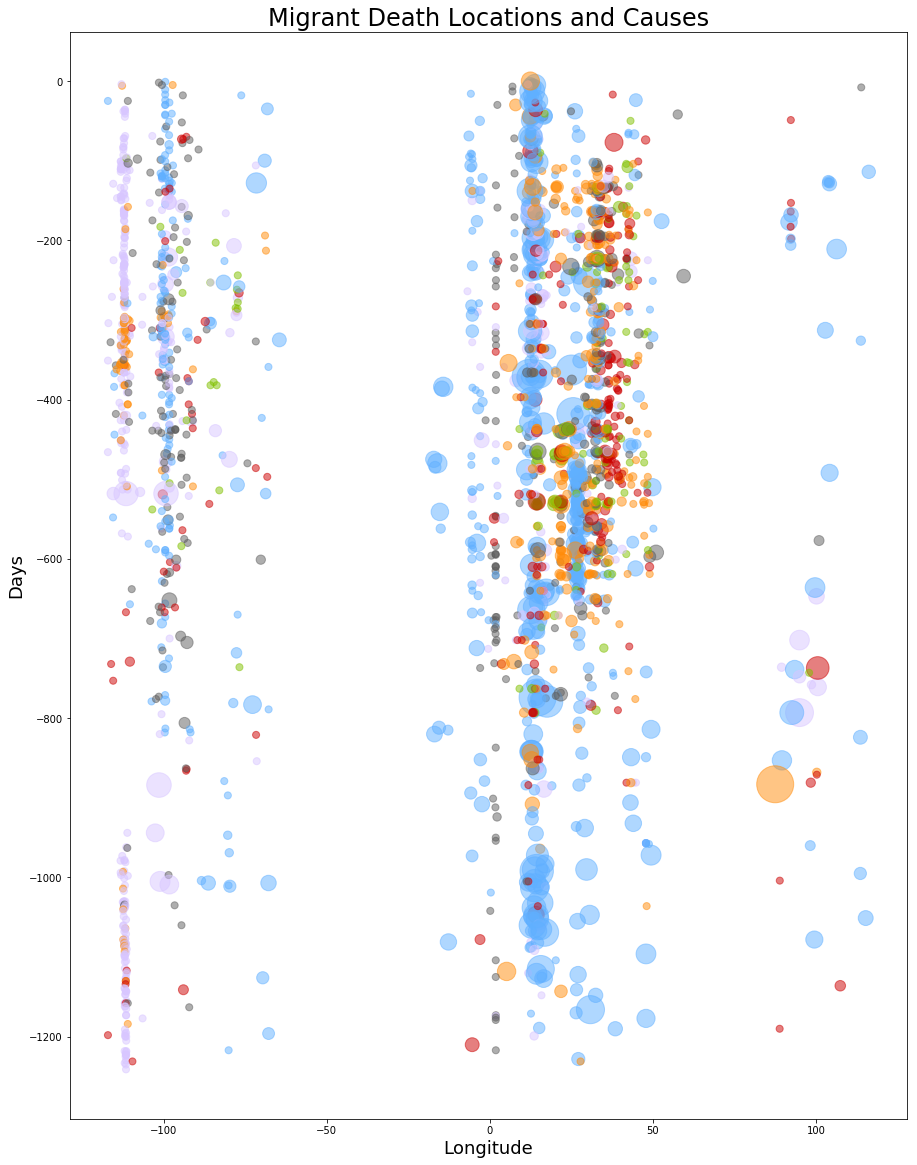

In [15]:
plt.figure(figsize=(15,20))
plt.scatter(data.lon,
            (data.date - data.date.max()).astype('timedelta64[D]'),
            s=50*np.sqrt(data.dead + data.missing),
            color=[CAUSE_COLORMAP[c[0]] for c in data.causes],
            alpha=0.5)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Days", fontsize=18)
plt.title("Migrant Death Locations and Causes", fontsize=24)
plt.show()

## Summary

I'm pleased with the new insights I've gained into this dataset by examining the cause of death field.  My experience with Python, in combination with Pandas, Matplotlib, and the Jupyter notebook made it relatively easy to explore the data and examine patterns graphically.  Overall, this workflow allowed for greater experimentation and examination of the underlying dataset, and this is a technique I would wish to continue using when analysing other data.

In terms of the visualizations, it is clear that matplotlib is somewhat more limited than D3.  While it is relatively easy to create graphs quickly, the degree of customization is somewhat lacking, and the programming model is less consistent as compared to working with D3.

For a Data Science workflow, I would choose to use Python/Pandas/Jupyter for data cleaning, exploration, analysis, machine learning, and (possibly) technical report writing.  Jupyter notebooks are powerful and very good for their openness and reproducibility.  However when it comes to putting polished, interactive visualizations into the hands of users, D3.js is clearly superior.


(array([ 811.,  191.,  360.,   10.,  269.,   92.,   65.,    0.,    0.,   61.]),
 array([  87.5396    ,   90.40813279,   93.27666558,   96.14519837,
          99.01373116,  101.88226395,  104.75079674,  107.61932953,
         110.48786232,  113.35639511,  116.2249279 ]),
 <a list of 10 Patch objects>)

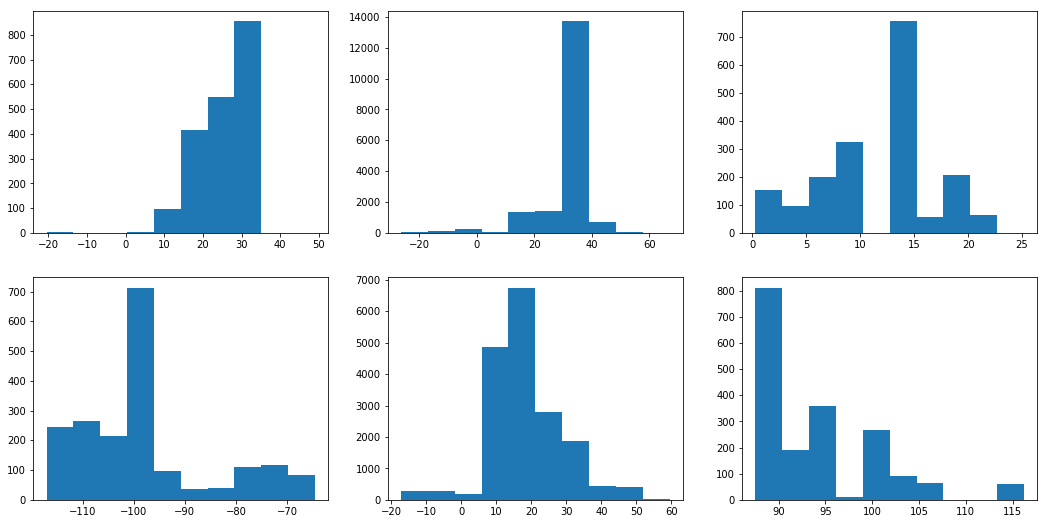

In [16]:
plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.hist(data.lat[data.lon < -50], weights=(data.dead + data.missing)[data.lon < -50])
plt.subplot(2, 3, 2)
plt.hist(data.lat[(-50 <= data.lon) & (data.lon < 75)], weights=(data.dead + data.missing)[(-50 <= data.lon) & (data.lon < 75)])
plt.subplot(2, 3, 3)
plt.hist(data.lat[data.lon >= 75], weights=(data.dead + data.missing)[data.lon >= 75])

plt.subplot(2, 3, 4)
plt.hist(data.lon[data.lon < -50], weights=(data.dead + data.missing)[data.lon < -50])
plt.subplot(2, 3, 5)
plt.hist(data.lon[(-50 <= data.lon) & (data.lon < 75)], weights=(data.dead + data.missing)[(-50 <= data.lon) & (data.lon < 75)])
plt.subplot(2, 3, 6)
plt.hist(data.lon[data.lon >= 75], weights=(data.dead + data.missing)[data.lon >= 75])

# Save Cleaned Data

The following step is used to save the cleaned data resulting from this notebook.

In [18]:
data.to_csv("../data/clean/migrants.csv")